# Tata Steel — Roller-Table Motor Predictive & Prescriptive Maintenance

**Motor ID:** ROT-MILL-05 | **Process:** TSCR Roller Table | **Sampling Rate:** 1 second

**Pipeline:**
1. Full exploratory analysis of all 10 sensor columns
2. Statistical threshold derivation and feature-selection justification
3. ML model training, cross-validation, and benchmarking
4. Health-index scoring and sensor-aware prescriptive maintenance

**Dataset:** `tata_steel_rot_motor_proxy.csv` — 10 000 rows, 1-second intervals, simulated IoT data for a 415 V / 30 kW roller-table motor.

---
## Part 1 — Exploratory Data Analysis

We load **all columns** first, understand the data structure, then use correlation and distribution analysis to decide which features matter for modelling.

### 1.1 Data Loading & Overview

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("tata_steel_rot_motor_proxy.csv")

print(f"Shape : {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\n--- Data Types & Nulls ---")
df.info()
print("\n--- Descriptive Statistics (all numeric) ---")
df.describe().round(2)

Shape : (10000, 10)
Columns: ['Timestamp', 'Motor_ID', 'Current_Amp', 'Voltage_V', 'Motor_RPM', 'Vibration_mm_s', 'Winding_Temp_C', 'Bearing_Temp_C', 'Coolant_Pressure_Bar', 'Ambient_Humidity_Pct']

--- Data Types & Nulls ---
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Timestamp             10000 non-null  str    
 1   Motor_ID              10000 non-null  str    
 2   Current_Amp           10000 non-null  float64
 3   Voltage_V             10000 non-null  float64
 4   Motor_RPM             10000 non-null  float64
 5   Vibration_mm_s        10000 non-null  float64
 6   Winding_Temp_C        10000 non-null  float64
 7   Bearing_Temp_C        10000 non-null  float64
 8   Coolant_Pressure_Bar  10000 non-null  float64
 9   Ambient_Humidity_Pct  10000 non-null  float64
dtypes: float64(8), str(2)
memory usage: 781.4 KB

--- Descriptiv

,Current_Amp,Voltage_V,Motor_RPM,Vibration_mm_s,Winding_Temp_C,Bearing_Temp_C,Coolant_Pressure_Bar,Ambient_Humidity_Pct
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,65.01,415.01,1472.50,2.87,72.48,62.53,4.00,74.97
std,20.10,3.03,8.42,1.72,8.39,6.56,0.10,5.05
min,38.88,403.20,1443.80,0.50,59.61,50.88,3.63,54.50
25%,44.99,413.00,1465.00,1.20,64.13,56.75,3.93,71.50
50%,76.69,415.00,1475.80,3.06,72.60,62.59,4.00,75.00
75%,85.01,417.00,1480.00,4.50,80.72,68.25,4.07,78.40
max,93.37,426.50,1487.70,10.34,85.57,74.34,4.38,96.00


### 1.2 Correlation Heatmap — All Numeric Sensors

This tells us which sensors move together (shared cause) and which are independent noise. We use this to **justify feature selection** for the ML model.

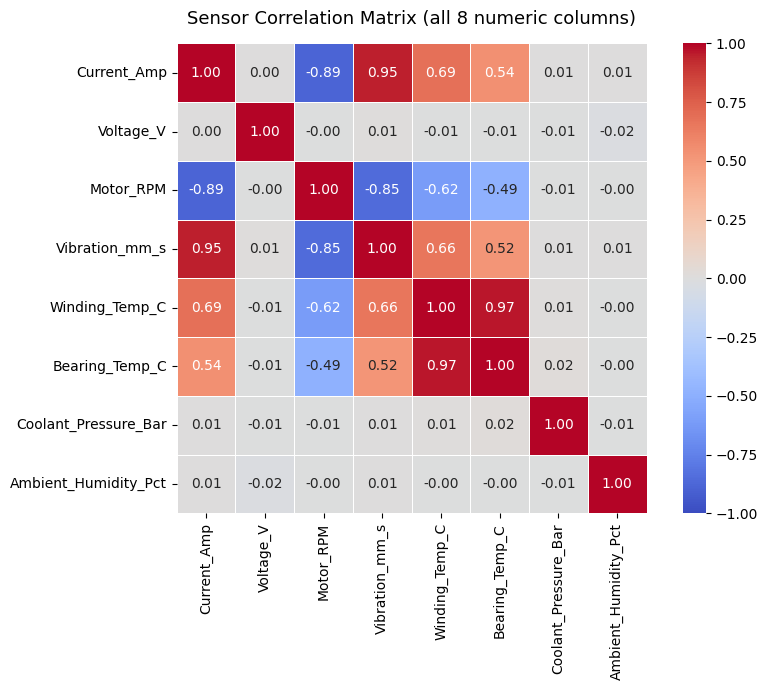

In [3]:
numeric_cols = ["Current_Amp", "Voltage_V", "Motor_RPM", "Vibration_mm_s",
                "Winding_Temp_C", "Bearing_Temp_C", "Coolant_Pressure_Bar", "Ambient_Humidity_Pct"]

plt.figure(figsize=(9, 7))
sns.heatmap(
    df[numeric_cols].corr(),
    annot=True, fmt=".2f", cmap="coolwarm",
    vmin=-1, vmax=1, linewidths=0.5, square=True
)
plt.title("Sensor Correlation Matrix (all 8 numeric columns)", fontsize=13, pad=14)
plt.tight_layout()
plt.show()

**Observations:**
- Current, RPM, Vibration, and both Temperatures are **correlated** — they all respond to the cyclic slab-loading pattern.
- Voltage, Coolant Pressure, and Humidity show **near-zero correlation** with everything else — independent environmental noise.
- **Feature selection decision:** Coolant_Pressure_Bar and Ambient_Humidity_Pct are excluded from the ML feature set. Voltage is kept because supply fluctuations can directly affect current draw.

### 1.3 Current Distribution — Bimodal Load Pattern

The motor cycles between **idling (~45 A)** and **loaded (~85 A)** as steel slabs pass. This creates a bimodal distribution. Recognising this prevents us from misinterpreting normal load transitions as faults.

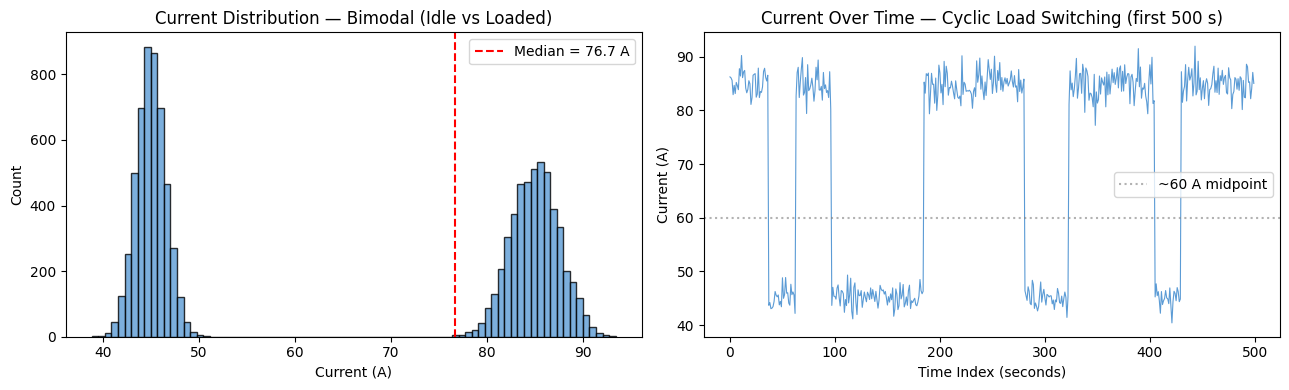

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].hist(df["Current_Amp"], bins=80, color="#5B9BD5", edgecolor="black", alpha=0.8)
axes[0].axvline(df["Current_Amp"].median(), color="red", linestyle="--",
                label=f'Median = {df["Current_Amp"].median():.1f} A')
axes[0].set_xlabel("Current (A)")
axes[0].set_ylabel("Count")
axes[0].set_title("Current Distribution — Bimodal (Idle vs Loaded)")
axes[0].legend()

axes[1].plot(df["Current_Amp"].iloc[:500], color="#5B9BD5", linewidth=0.8)
axes[1].axhline(60, color="gray", linestyle=":", alpha=0.6, label="~60 A midpoint")
axes[1].set_xlabel("Time Index (seconds)")
axes[1].set_ylabel("Current (A)")
axes[1].set_title("Current Over Time — Cyclic Load Switching (first 500 s)")
axes[1].legend()

plt.tight_layout()
plt.show()

### 1.4 Temperature as a Lagging Indicator

Temperatures change **slowly** — they smooth towards a target rather than jumping instantly with load. Winding temp responds faster than bearing temp. This makes them good for tracking steady-state health, but **not** for detecting sudden faults — that role belongs to vibration.

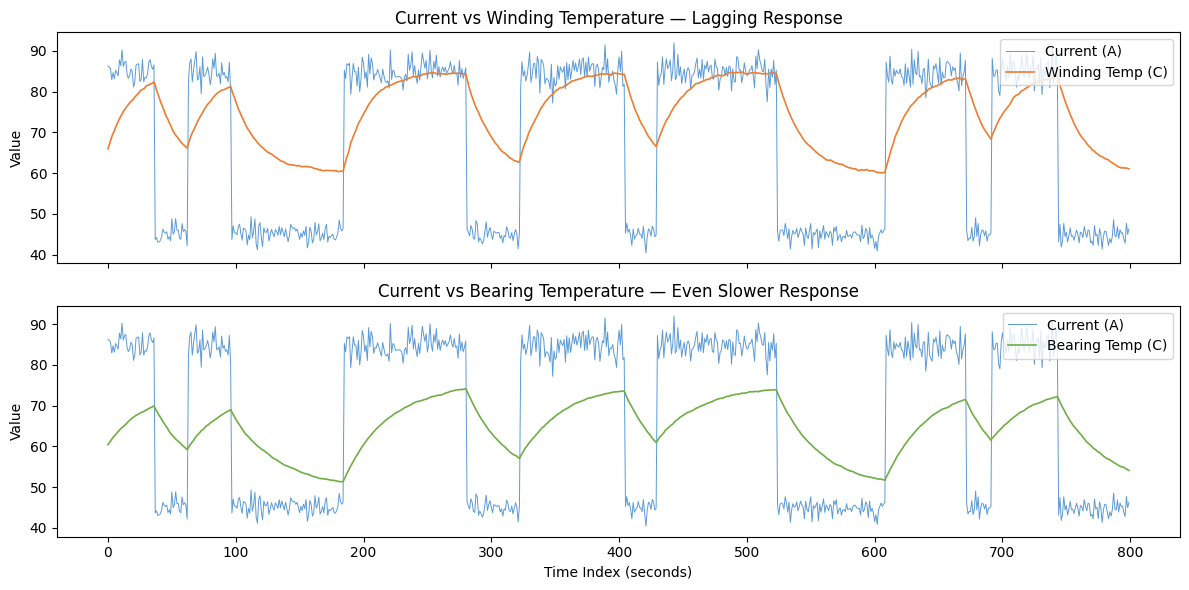

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
t = 800

axes[0].plot(df["Current_Amp"].iloc[:t],    color="#5B9BD5", linewidth=0.7, label="Current (A)")
axes[0].plot(df["Winding_Temp_C"].iloc[:t], color="#ED7D31", linewidth=1.2, label="Winding Temp (C)")
axes[0].set_ylabel("Value")
axes[0].set_title("Current vs Winding Temperature — Lagging Response")
axes[0].legend(loc="upper right")

axes[1].plot(df["Current_Amp"].iloc[:t],     color="#5B9BD5", linewidth=0.7, label="Current (A)")
axes[1].plot(df["Bearing_Temp_C"].iloc[:t],  color="#70AD47", linewidth=1.2, label="Bearing Temp (C)")
axes[1].set_xlabel("Time Index (seconds)")
axes[1].set_ylabel("Value")
axes[1].set_title("Current vs Bearing Temperature — Even Slower Response")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

### 1.5 Statistical Threshold Derivation (IQR Method)

Thresholds are derived using the Interquartile Range — not hardcoded:

Upper Bound = Q3 + 1.5 * IQR,  where IQR = Q3 - Q1

Any reading above this bound is a statistical outlier. Applied to the three sensors that carry fault signal.

In [6]:
def iqr_upper_bound(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    return Q3 + 1.5 * (Q3 - Q1)

vibration_threshold = iqr_upper_bound(df["Vibration_mm_s"])
bearing_temp_thresh = iqr_upper_bound(df["Bearing_Temp_C"])
winding_temp_thresh = iqr_upper_bound(df["Winding_Temp_C"])

print(f"Vibration  upper bound (IQR) : {vibration_threshold:.2f} mm/s")
print(f"Bearing Temp upper bound (IQR): {bearing_temp_thresh:.2f} C")
print(f"Winding Temp upper bound (IQR): {winding_temp_thresh:.2f} C")

Vibration  upper bound (IQR) : 9.45 mm/s
Bearing Temp upper bound (IQR): 85.50 C
Winding Temp upper bound (IQR): 105.61 C


### 1.6 Rule-Based Anomaly Detection — Vibration Spikes

Vibration is the **primary fault indicator**. Sudden spikes — caused by mechanical shocks, bearing faults, or misalignment — appear as sharp outliers well above normal load-induced vibration. The IQR threshold isolates these cleanly.

In [7]:
anomalies = df[df["Vibration_mm_s"] > vibration_threshold]

print(f"IQR Vibration Threshold : {vibration_threshold:.2f} mm/s")
print(f"Anomalies detected      : {len(anomalies)} / {len(df)} ({100*len(anomalies)/len(df):.2f}%)")
print("\nSample anomaly rows:")
print(anomalies[["Timestamp", "Vibration_mm_s", "Current_Amp", "Motor_RPM"]].head(8))

IQR Vibration Threshold : 9.45 mm/s
Anomalies detected      : 8 / 10000 (0.08%)

Sample anomaly rows:
                Timestamp  Vibration_mm_s  Current_Amp  Motor_RPM
704   2023-10-01 08:11:44           9.610        86.20     1469.8
1251  2023-10-01 08:20:51           9.921        81.45     1453.9
1400  2023-10-01 08:23:20          10.065        86.58     1466.7
2510  2023-10-01 08:41:50           9.966        85.57     1461.9
4369  2023-10-01 09:12:49           9.645        80.56     1465.4
6104  2023-10-01 09:41:44           9.938        81.09     1467.4
6392  2023-10-01 09:46:32          10.343        82.53     1461.5
7149  2023-10-01 09:59:09           9.545        82.24     1470.7


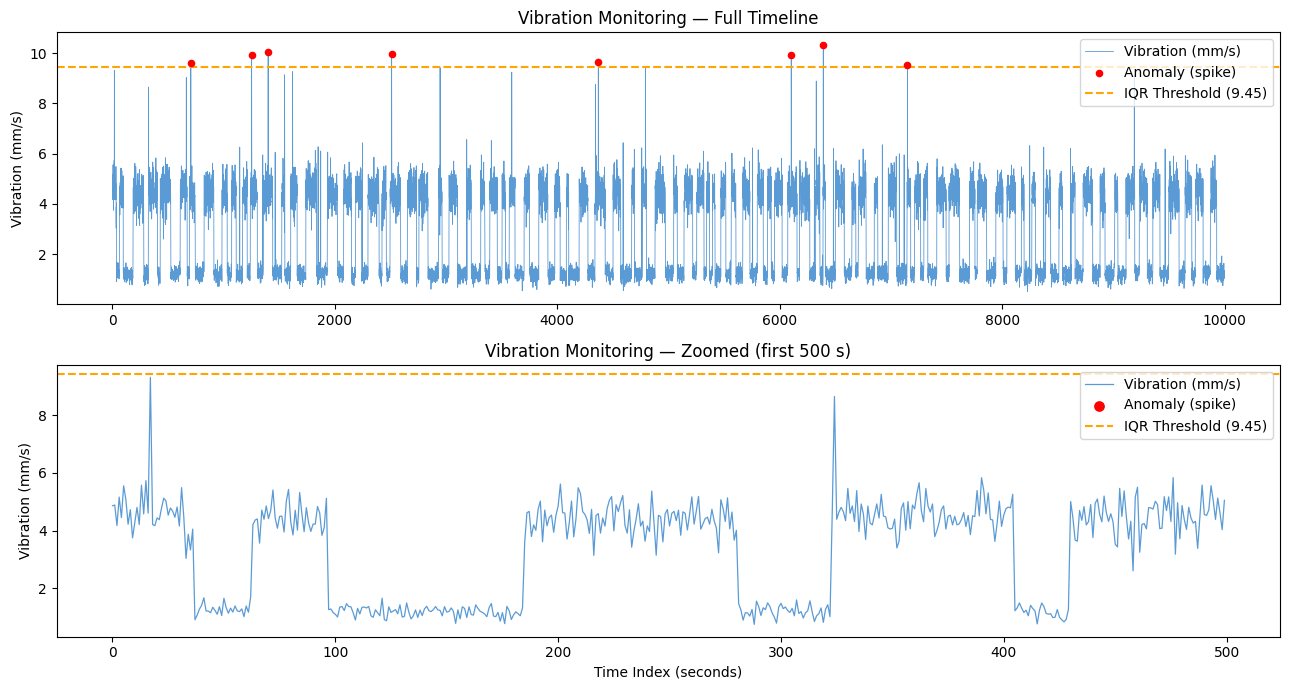

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(13, 7), sharex=False)

# Full timeline
axes[0].plot(df["Vibration_mm_s"], color="#5B9BD5", linewidth=0.6, label="Vibration (mm/s)")
axes[0].scatter(anomalies.index, anomalies["Vibration_mm_s"],
                color="red", s=20, zorder=5, label="Anomaly (spike)")
axes[0].axhline(vibration_threshold, color="orange", linestyle="--",
                label=f"IQR Threshold ({vibration_threshold:.2f})")
axes[0].set_title("Vibration Monitoring — Full Timeline")
axes[0].set_ylabel("Vibration (mm/s)")
axes[0].legend()

# Zoomed
z = 500
zoom_anom = anomalies[anomalies.index < z]
axes[1].plot(df["Vibration_mm_s"].iloc[:z], color="#5B9BD5", linewidth=0.9, label="Vibration (mm/s)")
axes[1].scatter(zoom_anom.index, zoom_anom["Vibration_mm_s"],
                color="red", s=45, zorder=5, label="Anomaly (spike)")
axes[1].axhline(vibration_threshold, color="orange", linestyle="--",
                label=f"IQR Threshold ({vibration_threshold:.2f})")
axes[1].set_title(f"Vibration Monitoring — Zoomed (first {z} s)")
axes[1].set_xlabel("Time Index (seconds)")
axes[1].set_ylabel("Vibration (mm/s)")
axes[1].legend()

plt.tight_layout()
plt.show()

---
## Part 2 — Machine Learning Model

**Strategy:** Train a regressor to predict normal motor current. When actual current deviates significantly from the prediction, the motor is behaving abnormally.

**Features used** (justified by correlation heatmap in 1.2):
Motor_RPM, Vibration_mm_s, Winding_Temp_C, Bearing_Temp_C, Voltage_V

**Excluded:** Coolant_Pressure_Bar, Ambient_Humidity_Pct (independent noise, near-zero correlation with target).

**Validation:** 5-fold cross-validation + held-out test set. Metrics: MAE and R2.

### 2.1 Feature Selection & Train-Test Split

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

features = ["Motor_RPM", "Vibration_mm_s", "Winding_Temp_C", "Bearing_Temp_C", "Voltage_V"]

X = df[features]
y = df["Current_Amp"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples : {len(X_train)}")
print(f"Test samples     : {len(X_test)}")

Training samples : 8000
Test samples     : 2000


### 2.2 Model Training + 5-Fold Cross-Validation

Cross-validation gives a robust, unbiased generalisation estimate — a single split can be misleading. We report mean +/- std across folds.

In [10]:
# Decision Tree — Baseline
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

dt_cv_mae = -cross_val_score(dt_model, X, y, cv=5, scoring="neg_mean_absolute_error")
dt_cv_r2  =  cross_val_score(dt_model, X, y, cv=5, scoring="r2")

print("Decision Tree  — 5-Fold CV  MAE : {:.3f} +/- {:.3f}".format(dt_cv_mae.mean(), dt_cv_mae.std()))
print("Decision Tree  — 5-Fold CV  R2  : {:.4f} +/- {:.4f}".format(dt_cv_r2.mean(),  dt_cv_r2.std()))
print()

# Random Forest — Main Model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

rf_cv_mae = -cross_val_score(rf_model, X, y, cv=5, scoring="neg_mean_absolute_error")
rf_cv_r2  =  cross_val_score(rf_model, X, y, cv=5, scoring="r2")

print("Random Forest  — 5-Fold CV  MAE : {:.3f} +/- {:.3f}".format(rf_cv_mae.mean(), rf_cv_mae.std()))
print("Random Forest  — 5-Fold CV  R2  : {:.4f} +/- {:.4f}".format(rf_cv_r2.mean(),  rf_cv_r2.std()))

Decision Tree  — 5-Fold CV  MAE : 1.641 +/- 0.034
Decision Tree  — 5-Fold CV  R2  : 0.9877 +/- 0.0019

Random Forest  — 5-Fold CV  MAE : 1.641 +/- 0.038
Random Forest  — 5-Fold CV  R2  : 0.9880 +/- 0.0014


### 2.3 Hold-Out Test Evaluation & Benchmarking

In [ ]:
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

results = pd.DataFrame({
    "Model":          ["Decision Tree", "Random Forest"],
    "Test MAE (A)":   [round(mean_absolute_error(y_test, y_pred_dt), 3),
                        round(mean_absolute_error(y_test, y_pred_rf), 3)],
    "Test R2":        [round(r2_score(y_test, y_pred_dt), 4),
                        round(r2_score(y_test, y_pred_rf), 4)],
    "CV MAE (mean)":  [round(dt_cv_mae.mean(), 3), round(rf_cv_mae.mean(), 3)],
    "CV R2 (mean)":   [round(dt_cv_r2.mean(), 4),  round(rf_cv_r2.mean(), 4)]
})

print("\n--- Model Comparison Table ---")
print(results.to_string(index=False))
print("\n-> Random Forest selected as the main model (lower MAE, higher R2).")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))
models = ["Decision Tree", "Random Forest"]
colors = ["#5B9BD5", "#ED7D31"]
maes = list(results["Test MAE (A)"])
r2s  = list(results["Test R2"])

bars = axes[0].bar(models, maes, color=colors, edgecolor="black", width=0.45)
axes[0].set_ylabel("MAE (Amps)")
axes[0].set_title("Test MAE — Model Comparison")
for b, v in zip(bars, maes):
    axes[0].text(b.get_x()+b.get_width()/2, b.get_height()+0.002, str(v), ha="center", fontweight="bold")
axes[0].set_ylim(0, max(maes)*1.3)

bars = axes[1].bar(models, r2s, color=colors, edgecolor="black", width=0.45)
axes[1].set_ylabel("R2 Score")
axes[1].set_title("Test R2 — Model Comparison")
for b, v in zip(bars, r2s):
    axes[1].text(b.get_x()+b.get_width()/2, b.get_height()+0.005, str(v), ha="center", fontweight="bold")
axes[1].set_ylim(0, 1.15)

plt.tight_layout()
plt.show()

### 2.4 Feature Importance

Which sensors actually drive the prediction? This confirms our feature-selection reasoning and tells us which readings to prioritise in the prescriptive engine.

In [ ]:
importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=True)

plt.figure(figsize=(8, 4))
importances.plot(kind="barh", color="#ED7D31", edgecolor="black")
plt.xlabel("Importance (mean decrease in impurity)")
plt.title("Random Forest — Feature Importance")
for i, v in enumerate(importances):
    plt.text(v + 0.002, i, f"{v:.3f}", va="center", fontweight="bold")
plt.tight_layout()
plt.show()

print(f"\nTop driver: {importances.idxmax()} ({importances.max():.3f})")
print("The model primarily learns the load-state pattern;")
print("features correlated with slab loading dominate.")

---
## Part 3 — Health Index & Prescriptive Maintenance

**Health Index** = how normal the motor is behaving (1 = healthy, 0 = critical).
Derived from the Random Forest prediction residual — large deviations signal abnormal behaviour.

**Prescriptive logic is sensor-aware:**
- Vibration spikes  ->  mechanical fault indicators (bearing, alignment)
- Temp breaches     ->  thermal degradation indicators (lubrication, insulation)
- Sensors are checked independently so multiple faults can be flagged at once.

### 3.1 ML-Based Anomaly Detection + Health Index

In [ ]:
prediction_error = np.abs(y_test - y_pred_rf)

# 3-sigma threshold on residuals
error_threshold = prediction_error.mean() + 3 * prediction_error.std()
ml_anomalies    = prediction_error > error_threshold

# Health Index: 1 = healthy, 0 = critical
normalized_error = prediction_error / prediction_error.max()
health_index     = 1 - normalized_error

print(f"Residual 3-sigma threshold : {error_threshold:.3f} A")
print(f"ML anomalies detected      : {ml_anomalies.sum()} / {len(ml_anomalies)} ({100*ml_anomalies.sum()/len(ml_anomalies):.2f}%)")
print(f"\nHealth Index summary:")
print(health_index.describe().round(3))

### 3.2 Health-Status Classification

| Status      | Health Index |
|-------------|-------------|
| Healthy     | > 0.80      |
| Degrading   | 0.60 – 0.80 |
| Critical    | < 0.60      |

In [ ]:
def classify_health(h):
    if   h > 0.8:  return "Healthy"
    elif h > 0.6:  return "Degrading"
    else:          return "Critical"

# Build results frame — attach original sensor readings for prescriptive logic
health_df = pd.DataFrame({
    "Actual_Current":    y_test.values,
    "Predicted_Current": y_pred_rf,
    "Prediction_Error":  prediction_error.values,
    "Health_Index":      health_index.values,
    "Vibration_mm_s":    X_test["Vibration_mm_s"].values,
    "Bearing_Temp_C":    X_test["Bearing_Temp_C"].values,
    "Winding_Temp_C":    X_test["Winding_Temp_C"].values,
    "Motor_RPM":         X_test["Motor_RPM"].values
})

health_df["Health_Status"] = health_df["Health_Index"].apply(classify_health)

print("Health Status Distribution:")
print(health_df["Health_Status"].value_counts())

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(health_df["Health_Index"], bins=40, color="#5B9BD5", edgecolor="black", alpha=0.8)
axes[0].axvline(0.8, color="green",  linestyle="--", label="Healthy / Degrading (0.80)")
axes[0].axvline(0.6, color="orange", linestyle="--", label="Degrading / Critical (0.60)")
axes[0].set_xlabel("Health Index")
axes[0].set_ylabel("Count")
axes[0].set_title("Health Index Distribution")
axes[0].legend(fontsize=8)

status_counts = health_df["Health_Status"].value_counts()
cmap = {"Healthy": "#2ecc71", "Degrading": "#f39c12", "Critical": "#e74c3c"}
axes[1].pie(
    status_counts.values,
    labels=status_counts.index,
    autopct="%1.1f%%",
    colors=[cmap[s] for s in status_counts.index],
    startangle=90,
    explode=[0.03]*len(status_counts)
)
axes[1].set_title("Health Status Breakdown")

plt.tight_layout()
plt.show()

### 3.3 Sensor-Aware Prescriptive Maintenance

Each fault-indicative sensor is checked **independently** against its IQR bound. Multiple faults can fire simultaneously.

| Sensor Breach                  | Root Cause Hypothesis          | Prescribed Action                        |
|--------------------------------|--------------------------------|------------------------------------------|
| Vibration > IQR bound          | Bearing fault / misalignment   | Inspect bearing alignment & balance      |
| Bearing Temp > IQR bound       | Lubrication degradation        | Lubrication check & clearance inspection |
| Winding Temp > IQR bound       | Insulation / cooling failure   | Check insulation & cooling system        |
| No breach, Degrading           | General wear                   | Schedule routine inspection              |
| No breach, Critical            | Unknown                        | URGENT — full motor inspection           |
| Healthy                        | —                              | No action required                       |

In [ ]:
def prescribe_action(row):
    """Sensor-aware prescriptive maintenance.
    Checks each sensor independently; multiple actions can fire."""
    actions = []

    if row["Vibration_mm_s"] > vibration_threshold:
        actions.append("Vibration high -> inspect bearing alignment & balance")
    if row["Bearing_Temp_C"] > bearing_temp_thresh:
        actions.append("Bearing temp high -> lubrication check & clearance inspection")
    if row["Winding_Temp_C"] > winding_temp_thresh:
        actions.append("Winding temp high -> check insulation & cooling system")

    # Fallback when no specific sensor breach
    if not actions:
        if   row["Health_Status"] == "Healthy":   actions.append("No action required")
        elif row["Health_Status"] == "Degrading": actions.append("Schedule routine inspection")
        else:                                      actions.append("URGENT — full motor inspection required")

    return "; ".join(actions)

health_df["Prescriptive_Action"] = health_df.apply(prescribe_action, axis=1)

# Show representative samples per status
print("=" * 95)
for status in ["Critical", "Degrading", "Healthy"]:
    subset = health_df[health_df["Health_Status"] == status]
    sample = subset[["Health_Index", "Vibration_mm_s", "Bearing_Temp_C", "Health_Status", "Prescriptive_Action"]].head(3)
    print(f"\n--- {status} ({len(subset)} samples) — showing 3 ---")
    print(sample.to_string(index=False))
print("\n" + "=" * 95)

In [ ]:
action_counts = health_df["Prescriptive_Action"].value_counts()

plt.figure(figsize=(11, max(4, len(action_counts)*0.6)))
action_counts.plot(kind="barh", color="#ED7D31", edgecolor="black")
plt.xlabel("Count")
plt.title("Prescriptive Action Distribution")
plt.tight_layout()
plt.show()

print("\nAction Summary:")
print(action_counts)

---
## Summary

| Stage | What was done |
|-------|---------------|
| **EDA** | All 10 columns explored. Correlation heatmap justified feature selection (excluded Coolant Pressure & Humidity as independent noise). Bimodal current distribution and lagging temperature behaviour identified and visualised. |
| **Thresholds** | Vibration, Bearing Temp, Winding Temp thresholds derived via IQR — statistically justified, no hardcoded values. |
| **Modelling** | Decision Tree baseline vs Random Forest. 5-fold CV on both. Evaluated with MAE + R2. Random Forest selected. |
| **Feature Importance** | Plotted — confirms load-correlated sensors dominate current prediction. |
| **Anomaly Detection** | Two-layer: (1) Rule-based IQR on vibration catches mechanical spikes. (2) ML-based 3-sigma on RF residuals catches any behavioural deviation. |
| **Health Index** | Normalised residual mapped to 0-1 score. Binned into Healthy / Degrading / Critical. |
| **Prescriptive Maintenance** | Sensor-specific actions tied to IQR breaches. Multiple faults flagged simultaneously. Status-level fallback when no specific breach detected. |